# Pentode Modeling
* Model Parameter Extraction
* Model Parameter Verification

This experiment uses data extracted from a vacuum tube datasheet and scipy.optimize to calculate the [Child-Langmuir](http://www.john-a-harper.com/tubes201/) parameters used for circuit simulation.

$$I_a = K (V_{g1k} + D_{g2}V_{g2k} + D_aV_{ak})^{3/2}$$

Now we're adding the van der Veen K modifier,

$$\alpha = \alpha_0(({2/\pi})\arctan (V_{ak}/V_{g2k}))^{1/n}$$

$$I_a = \alpha K (V_{g1k} + D_{g2}V_{g2k} + D_aV_{ak})^{3/2}$$

$$I_a = \alpha_0(({2/\pi})\arctan(V_{ak}/V_{g2k}))^{1/n} K (V_{g1k} + D_{g2}V_{g2k} + D_aV_{ak})^{3/2}$$



We are going to use curve fitting to determine $$K, D_a, D_{g2},\alpha_0, \text{  and  } n$$ 

Then we can use [Leach's pentode](users.ece.gatech.edu/mleach/papers/tubeamp/tubeamp.pdf) SPICE model with the van der Veen modifier.

In [28]:
import scipy
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from math import pi,atan


Starting with the [Philips EL34 data sheet](data/el34-philips-1958.pdf), create a PNG of the 
![EL34 Philips 1958 @ 360V](data/el34-philips-1958-360V.png)
import this image into [engauge](https://github.com/markummitchell/engauge-digitizer)

Create 9 curves then use 'curve point tool' to add points to each curve
![ecc83-philips-1954.dig.screen1.png](data/ecc83-philips-1954.dig.screen1.png)

Change export options, "Raw Xs and Ys" and "One curve on each line", otherwise engauge will do some interrupting of your points
![engauge export settings](data/engauge-export-settings.png)
export a csv file

In [2]:
%cat data/el34-philips-1958-360V.csv


x,Curve1
9.66,0.17962
22.99,0.26382
41.49,0.3227
70.55,0.37863
116.61,0.42335
167.87,0.44981
208.47,0.45979

x,Curve2
10.69,0.14899
31.64,0.22789
55.38,0.27793
80.22,0.30912
107.97,0.3356
142.14,0.35266
183.36,0.36911
233.38,0.38262
270.44,0.38907

x,Curve3
10.54,0.11601
26.63,0.16252
49.13,0.19902
79.27,0.23256
112.89,0.25786
159.43,0.27962
208.86,0.29312
259.46,0.30309
315.33,0.31012
358.25,0.31244

x,Curve4
10.97,0.08244
35.85,0.12306
66.58,0.15896
102.56,0.18602
159.69,0.2113
217.95,0.22657
280.3,0.23653
338.51,0.24061
419.65,0.24643
489.03,0.24991

x,Curve5
10.89,0.06595
47.46,0.09301
83.43,0.11831
125.86,0.14183
195.91,0.16298
295.88,0.17409
379.38,0.18109
469.93,0.1875
644.55,0.20032

x,Curve6
12.53,0.04004
29.04,0.05121
49.61,0.05002
73.19,0.0659
115.62,0.08884
176.84,0.10822
243.3,0.11642
443.79,0.12922
740.72,0.15077

x,Curve7
10.73,0.03179
36.62,0.03707
66,0.03646
117.81,0.05468
194.3,0.0717
275.44,0.07693
381.26,0.08156
498.26,0.08913
745.19,0.10189

x,Curve8
11.26,0.01884


Need to create scipy array like this

x = scipy.array( [[360, -0.0, 9.66], [360, -0.0, 22.99], ...

y = scipy.array( [0.17962, 0.26382, 0.3227, 0.37863, ...

Vaks = scipy.array( [9.66, 22.99, 41.49, 70.55, 116.61, ...

from the extracted curves

In [29]:
fname = "data/el34-philips-1958-360V.csv"
f = open(fname,'r').readlines()

deltaVgk = -4.0
exp = 1.50


VgkVak = []
Iak    = []
Vaks   = []

f = open(fname,'r').readlines()

vg2k = 360

for l in f:
    l = l.strip()
    if len(l): # skip blank lines
        if l[0] == 'x':
            vn = float(l.split("Curve")[1]) - 1.0
            Vgk = vn * deltaVgk
            continue
        else:
            (Vak,i) = l.split(',')
        VgkVak.append([vg2k,float(Vgk),float(Vak)])
        Iak.append(float(i))
        Vaks.append(float(Vak))

x = scipy.array(VgkVak)
y = scipy.array(Iak)
Vaks = scipy.array(Vaks)

In [30]:
%matplotlib inline
def func(x,K,Da,Dg2,a0,n):
    rv = []
    for VV in x:
        Vg2k = VV[0]
        Vg1k = VV[1]
        Vak  = VV[2]
        t = Vg1k + Dg2 * Vg2k + Da * Vak

        if t > 0:
            a = a0 * ((2/pi) * atan(Vak/Vg2k))**(1/n)
            Ia = a * K * t**exp
        else:
            Ia = 0
        # print "func",Vg2k,Vg1k,Vak,t,K,Da,Dg2,a0,n
        rv.append(Ia)

    return rv

popt, pcov = curve_fit(func, x, y,p0=[0.5,0.5,0.5,0.2,5])
#print popt,pcov

(K,Da,Dg2,a0,n) = popt
print "K   =",K
print "Da  =",Da
print "Dg2 =",Dg2
print "a0  =",a0
print "n   =",n


K   = 0.249735634398
Da  = 0.00177974599958
Dg2 = 0.0901811834128
a0  = 0.0128106457073
n   = 3.80389659062


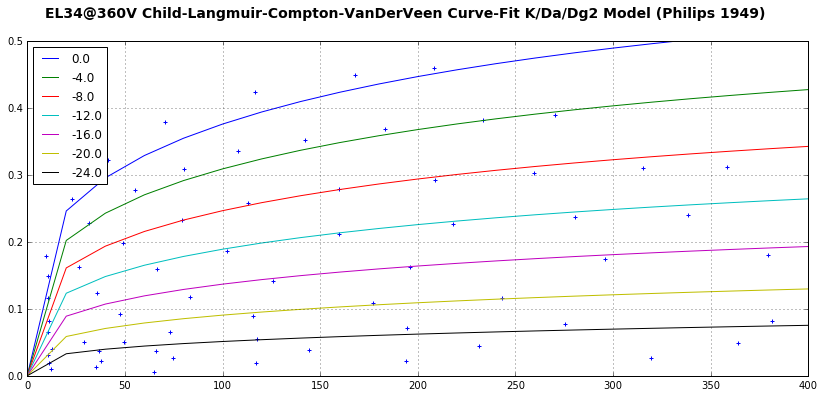

In [27]:
Vg2k = x[0][0]

def IaCalc(Vg1k,Vak):
    t = Vg1k + Dg2 * Vg2k + Da * Vak
    if t > 0:
        a = a0 * ((2/pi) * atan(Vak/Vg2k))**(1/n)
        Ia = a * K * t**exp
    else:
        Ia = 0
    # print "IaCalc",Vgk,Vak,t,Ia
    return Ia

Vgk = np.linspace(0,-24,7)
Vak = np.linspace(0,400,21)

vIaCalc = np.vectorize(IaCalc,otypes=[np.float])

Ia = vIaCalc(Vgk[:,None],Vak[None,:])

plt.figure(figsize=(14,6))

for i in range(len(Vgk)):
    plt.plot(Vak,Ia[i],label=Vgk[i])

plt.scatter(Vaks,y,marker="+")

plt.legend(loc='upper left')
plt.suptitle('EL34@%dV Child-Langmuir-Compton-VanDerVeen Curve-Fit K/Da/Dg2 Model (Philips 1949)'%Vg2k, fontsize=14, fontweight='bold')
plt.grid()
plt.ylim((0,0.5))
plt.xlim((0,400))
plt.show()
